In [2]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.decomposition import NMF,PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
DATAPATH = "data/digits.csv"
image_shape=(28,28)

In [3]:
df = pd.read_csv(DATAPATH)
#df_s = df.sort_values('label')
y = df["label"].values
labels = df["label"] 
X = df.drop("label",axis=1).values/255
org_X = df.drop("label",axis=1)
#print(df.head())
#print(df.shape)
#print(y)
#print(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [5]:
pca = PCA(n_components=15,random_state=0)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
    ]
clf = svm.SVC(parameters)


clf = GridSearchCV(clf, parameters, verbose=2,n_jobs=-1)
clf.fit(X_train_pca,y_train)
test_score = clf.score(X_test_pca,y_test)
y_pred_pca = clf.predict(X_test_pca)
print(test_score)
print(metrics.classification_report(y_test, y_pred_pca, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred_pca, labels=range(10)))

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  5.3min finished


0.947
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       211
          1       0.99      0.99      0.99       221
          2       0.95      0.95      0.95       215
          3       0.92      0.89      0.91       190
          4       0.96      0.95      0.96       199
          5       0.97      0.92      0.95       182
          6       0.96      0.96      0.96       205
          7       0.95      0.95      0.95       203
          8       0.89      0.97      0.93       176
          9       0.93      0.91      0.92       198

avg / total       0.95      0.95      0.95      2000

[[204   0   0   0   2   1   3   0   0   1]
 [  0 218   0   1   0   0   0   0   1   1]
 [  0   1 205   1   2   0   0   5   1   0]
 [  3   1   3 170   0   3   0   1   9   0]
 [  0   0   1   0 190   0   2   0   0   6]
 [  1   0   1   4   0 168   1   0   4   3]
 [  4   0   1   1   0   1 196   0   2   0]
 [  2   0   4   0   1   0   1 192   0   3]
 [  0   0  

In [6]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


0.9999742070254674
0.9999756244018205
0.9999769343637126
0.9999781993255481
0.9999794560708856
0.9999806327900338
0.9999817367381845
0.9999828159533616
0.9999838750561726
0.9999848057112124
0.9999857144304798
0.9999865653230251
0.9999873678282136
0.9999881404713687
0.9999888844055639
0.9999896316269762
0.9999903158480568
0.9999909644987793
0.9999916087814449
0.9999922273077771
0.9999927926010532
0.9999933444603327
0.999993879868631
0.9999943732655583
0.999994860689367
0.9999953293158735
0.9999957780275744
0.9999962179792484
0.9999966511030763
0.9999970305290851
0.9999973251836882
0.9999975996281256
0.9999978579912193
0.9999981084767514
0.9999983490137281
0.9999985859831722
0.9999987720101466
0.9999989394564525
0.9999990671610854
0.9999991905579061
0.9999993133428263
0.9999994304819965
0.9999995425133885
0.999999640652607
0.9999997206189019
0.9999997802193925
0.9999998371120083
0.9999998827917561
0.9999999270329558
0.9999999565238745
0.9999999790185901
0.9999999875155756
0.9999999952690

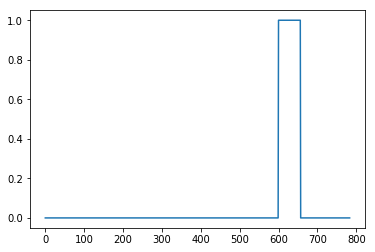

In [7]:
E_list = np.zeros(784)
cumsum_explained = np.zeros(784)
for i in range(600,784):
    pca = PCA(n_components = i)  # 主成分分析オブジェクトの作成
    pca.fit(X_train)                       # 主成分分析の実行
    transformed = pca.transform(X_train)   # データに対して削減後のベクトルを生成
    E = pca.explained_variance_ratio_        # 寄与率
    cumsum_explained[i] = np.cumsum(E)[::-1][0]
    if cumsum_explained[i] == cumsum_explained[i-1]:
        print(i)
        break
    print(cumsum_explained[i])
plt.plot(cumsum_explained)
plt.show()

In [18]:
pca = PCA(n_components = 784,random_state=0)  # 主成分分析オブジェクトの作成
pca.fit(X_train)  # 主成分分析の実行
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
parameter = [{"C":[1000],"kernel":["rbf"],"gamma":[0.001]}]
clf = svm.SVC(parameter)
clf.fit(X_train_pca,y_train)
test_score = clf.score(X_test_pca,y_test)
y_pred_pca = clf.predict(X_test_pca)
print(test_score)
print(metrics.classification_report(y_test, y_pred_pca, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred_pca, labels=range(10)))

TypeError: must be real number, not list